In [1]:
from utils import *

Test triangulation error with exact pose matrices but random offsets applied to pixel localizations of the bubbles

In [2]:
c1 = create_sensor(sensor_number=1)
c2 = create_sensor(sensor_number=2)
c3 = create_sensor(sensor_number=3)

# Extract projection matrices from sensors
c1pose_actual = np.array(c1['to_world'].matrix)[:3,:]
c2pose_actual = np.array(c2['to_world'].matrix)[:3,:]
c3pose_actual = np.array(c3['to_world'].matrix)[:3,:]
actual_poses = np.stack([c1pose_actual, c2pose_actual, c3pose_actual])

inv_actual_poses = compute_inverse_pose_matrices(actual_poses)

print(actual_poses)

[[[-6.56510830e-01 -7.29643881e-01  1.91346124e-01 -5.96334600e+00]
  [-6.56510830e-01  6.77617311e-01  3.31403643e-01 -1.03287039e+01]
  [-3.71466011e-01  9.19492841e-02 -9.23882246e-01  1.78488827e+01]]

 [[ 9.23874855e-01 -8.44208353e-06 -3.82694721e-01  1.19286947e+01]
  [ 0.00000000e+00 -1.00000000e+00  2.20595775e-05 -2.20595775e-05]
  [-3.82694721e-01 -2.03802883e-05 -9.23874855e-01  1.78498745e+01]]

 [[-6.56507790e-01  7.29646504e-01  1.91346720e-01 -5.96384668e+00]
  [ 6.56507790e-01  6.77613378e-01 -3.31417680e-01  1.03296175e+01]
  [-3.71476769e-01 -9.19576734e-02 -9.23877120e-01  1.78518772e+01]]]


In [3]:
# Create default grid for use later
cparams = default_cylindrical_grid_params
grid = generate_cylindrical_grid(**cparams)

In [4]:
# project the points directly onto the image plane using the actual camera poses
actualp1 = []
actualp2 = []
actualp3 = []
inv_actual_poses = compute_inverse_pose_matrices(actual_poses)
for point in grid:
    actualp1.append(normalized_to_pixel(reproject(inv_actual_poses[0], point)))
    actualp2.append(normalized_to_pixel(reproject(inv_actual_poses[1], point)))
    actualp3.append(normalized_to_pixel(reproject(inv_actual_poses[2], point)))
actualp1 = np.array(actualp1)
actualp2 = np.array(actualp2)
actualp3 = np.array(actualp3)

In [5]:
largest_offset_pixels = 5 * 3/2
n = 100 # number of different random max pixel offsets
m = 20 # number of runs per max pixel offset

average_triangulation_errors = []

# Test n different random max pixel offsets
for i in range(0, n+1):

    max_offset = largest_offset_pixels * i/n

    # Keep track of the errors for this max offset...
    ate = []

    # For each max pixel offset, do m runs
    for j in range(m):

        predictions = []
        for i in range(len(grid)):
            clocs = np.stack([actualp1[i]+random_in_unit_circle()*max_offset, actualp2[i]+random_in_unit_circle()*max_offset, actualp3[i]+random_in_unit_circle()*max_offset])
            clocs = np.array([normalize_coordinate(c) for c in clocs])
            predictions.append(n_view_triangulate(actual_poses, clocs))
        predictions = np.array(predictions)

        # Calculate the triangulation errors (in centimeters)
        errors = []
        i = 0
        for pred in predictions:
            errors.append(np.linalg.norm(pred - grid[i]))
            i += 1
        errors = np.array(errors)
        ate.append(np.average(errors))

    average_triangulation_errors.append(np.average(ate))

print()
print(average_triangulation_errors)


[2.8393459126455032e-14, 0.0036515222618062246, 0.007357630498820653, 0.01110418880592042, 0.014716135617627635, 0.018332222825299074, 0.02205096974070438, 0.025805888523008153, 0.02942501702944782, 0.03315104931645179, 0.036783246914364, 0.040739717943592955, 0.04413052197513548, 0.047796136502288394, 0.051680218760416105, 0.055117190294296625, 0.058785930285220625, 0.06257355252158152, 0.06561326465864434, 0.0700402787507267, 0.07301466260086824, 0.0774171803295354, 0.08085807933490577, 0.08450295030746267, 0.0883262086109673, 0.09176644800009687, 0.09512549785284978, 0.09966542199222331, 0.10298711309982564, 0.1065802151353056, 0.11024119975284268, 0.11417927099931527, 0.11720164451719724, 0.12154237521505769, 0.12488264634008825, 0.12869870964131164, 0.13231403023544797, 0.13655116943511722, 0.14047940041043652, 0.143655476564211, 0.14769641065194156, 0.15127352064234337, 0.15467489051698857, 0.1577611813737934, 0.1619682742436669, 0.16460146416124705, 0.17066151723787015, 0.17280

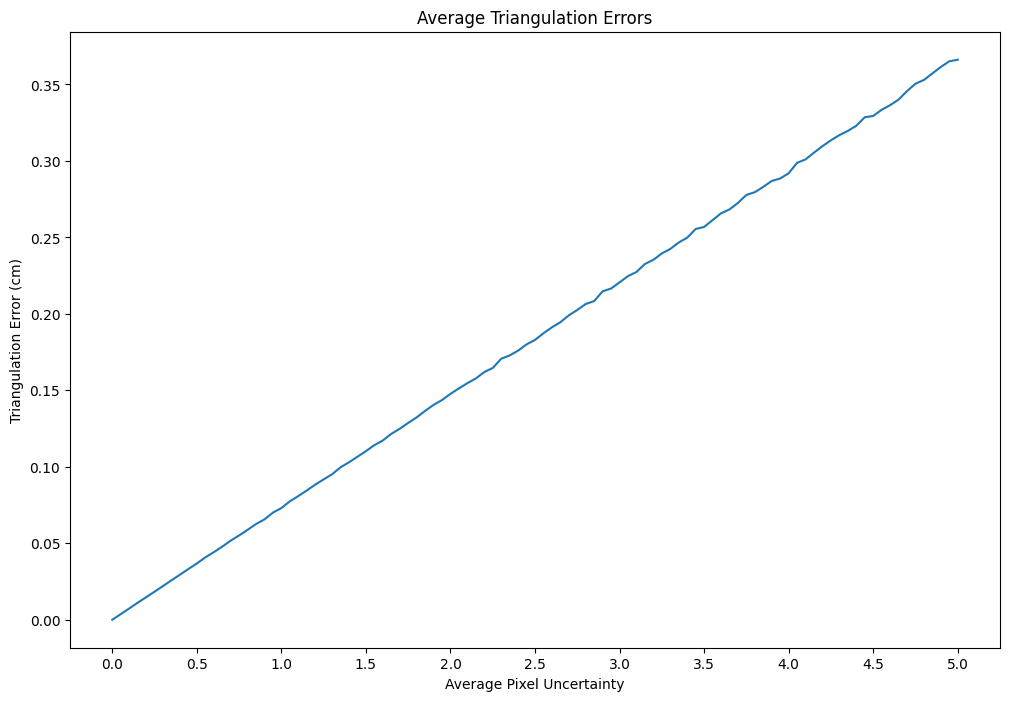

In [6]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
average_offset_pixels = largest_offset_pixels * 2/3 # average radius of point in unit circle is 2/3
xtick_labels = np.arange(0, average_offset_pixels + average_offset_pixels/n, average_offset_pixels/n * 10)
xticks = xtick_labels * (n)/average_offset_pixels

ax.set_title("Average Triangulation Errors")
ax.set_ylabel("Triangulation Error (cm)")
ax.set_xlabel("Average Pixel Uncertainty")
ax.set_xticks(xticks, xtick_labels)
ax.plot(average_triangulation_errors)

# fig.tight_layout()

In [7]:
# Solve for the coefficients of the line of best fit
xaxis = np.arange(0, average_offset_pixels + average_offset_pixels/n, average_offset_pixels/n)
coefs = np.polyfit(xaxis, average_triangulation_errors, 1)
print(coefs)

[7.35299778e-02 5.65600780e-05]


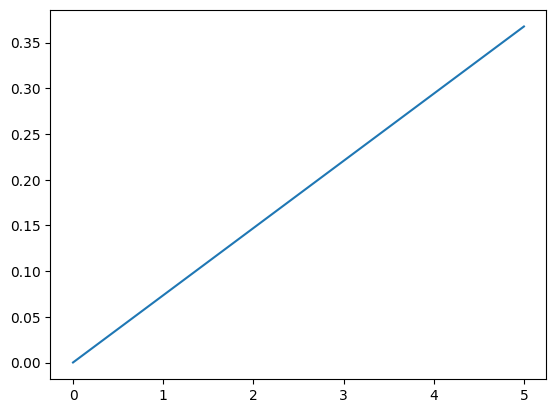

In [8]:
plt.plot(xaxis, np.poly1d(coefs)(xaxis))